In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_2(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2,dropout3,dropout4):
        super(DNN_2, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16,8)
        self.layer4 = nn.Linear(8,4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)


        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)

        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout3(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        x = self.dropout4(x)

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [5]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    dropout3 = trial.suggest_float("dropout3", 0, 0.5, step=0.05)
    dropout4 = trial.suggest_float("dropout4", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)

    # モデル定義
    model = DNN_2(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
        dropout3=dropout3,
        dropout4=dropout4
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()  
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [6]:
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:39:06,403] A new study created in memory with name: no-name-7c1ad357-7092-42b6-82e4-3bc48a6f4947


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:09,658] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.05, 'dropout2': 0.25, 'dropout3': 0.5, 'dropout4': 0.45, 'learning_rate': 0.003638267131166983, 'weight_rate': 0.0002169340442735761}. Best is trial 0 with value: 0.0.


Early stopping at epoch 17
Final MCC: 0.0000


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:13,570] Trial 1 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.35000000000000003, 'dropout3': 0.25, 'dropout4': 0.25, 'learning_rate': 0.005032699084463063, 'weight_rate': 0.03549035458290393}. Best is trial 0 with value: 0.0.


Early stopping at epoch 29
Final MCC: 0.0000


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:19,954] Trial 2 finished with value: 0.22544811448615248 and parameters: {'dropout1': 0.2, 'dropout2': 0.0, 'dropout3': 0.25, 'dropout4': 0.30000000000000004, 'learning_rate': 0.0021796176941039735, 'weight_rate': 0.0028135777160728996}. Best is trial 2 with value: 0.22544811448615248.


Early stopping at epoch 41
Final MCC: 0.2254


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:34,139] Trial 3 finished with value: 0.0 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.4, 'dropout4': 0.1, 'learning_rate': 0.00010500316946510076, 'weight_rate': 0.04199207762855429}. Best is trial 2 with value: 0.22544811448615248.


Final MCC: 0.0000


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:38,021] Trial 4 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.1, 'learning_rate': 0.04503919536146685, 'weight_rate': 0.00019962775685817015}. Best is trial 2 with value: 0.22544811448615248.


Early stopping at epoch 31
Final MCC: 0.0000


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:39:45,277] Trial 5 finished with value: 0.0 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'dropout3': 0.0, 'dropout4': 0.5, 'learning_rate': 0.0024896993072712806, 'weight_rate': 0.0001255575733834049}. Best is trial 2 with value: 0.22544811448615248.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated 

Early stopping at epoch 58
Final MCC: 0.0000


[I 2024-12-18 13:39:59,938] Trial 7 finished with value: 0.04346094701818343 and parameters: {'dropout1': 0.25, 'dropout2': 0.2, 'dropout3': 0.1, 'dropout4': 0.30000000000000004, 'learning_rate': 0.00023729633153676634, 'weight_rate': 0.000591291605016035}. Best is trial 2 with value: 0.22544811448615248.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:40:00,067] Trial 8 pruned. 


Final MCC: 0.0435


[I 2024-12-18 13:40:00,207] Trial 9 pruned. 
[I 2024-12-18 13:40:09,774] Trial 10 finished with value: 0.18816168852036438 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'dropout3': 0.30000000000000004, 'dropout4': 0.0, 'learning_rate': 0.0006213284048616561, 'weight_rate': 0.0030207630098574487}. Best is trial 2 with value: 0.22544811448615248.


Early stopping at epoch 72
Final MCC: 0.1882


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:40:17,328] Trial 11 finished with value: 0.2307607514133131 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'dropout3': 0.30000000000000004, 'dropout4': 0.0, 'learning_rate': 0.0006234665697245712, 'weight_rate': 0.0024132897911792912}. Best is trial 11 with value: 0.2307607514133131.
/tmp/ipykernel_41739/1497034159.py:7: Future

Early stopping at epoch 56
Final MCC: 0.2308


[I 2024-12-18 13:40:28,055] Trial 13 finished with value: 0.1352320203935006 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'dropout3': 0.2, 'dropout4': 0.35000000000000003, 'learning_rate': 0.0006367462372691636, 'weight_rate': 0.008720351405753226}. Best is trial 11 with value: 0.2307607514133131.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:40:28,188] Trial 14 pruned. 

Early stopping at epoch 78
Final MCC: 0.1352


[I 2024-12-18 13:40:28,332] Trial 15 pruned. 
[I 2024-12-18 13:40:41,337] Trial 16 finished with value: 0.008563562529496246 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'dropout3': 0.2, 'dropout4': 0.35000000000000003, 'learning_rate': 0.0002637680136957854, 'weight_rate': 0.00045557187810678644}. Best is trial 11 with value: 0.2307607514133131.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-

Final MCC: 0.0086


[I 2024-12-18 13:40:41,682] Trial 18 pruned. 
[I 2024-12-18 13:40:41,847] Trial 19 pruned. 
[I 2024-12-18 13:40:42,020] Trial 20 pruned. 
[I 2024-12-18 13:40:52,889] Trial 21 finished with value: 0.15071008827438734 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'dropout3': 0.30000000000000004, 'dropout4': 0.0, 'learning_rate': 0.0005753000783780759, 'weight_rate': 0.002576034931075754}. Best is trial 11 with value: 0.2307607514133131.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

Early stopping at epoch 82
Final MCC: 0.1507


[I 2024-12-18 13:41:06,434] Trial 23 finished with value: 0.28079378972351476 and parameters: {'dropout1': 0.2, 'dropout2': 0.0, 'dropout3': 0.25, 'dropout4': 0.05, 'learning_rate': 0.00014656408485957785, 'weight_rate': 0.0006078065333843467}. Best is trial 23 with value: 0.28079378972351476.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:41:06,606] Trial 24 pruned. 


Final MCC: 0.2808


[I 2024-12-18 13:41:06,783] Trial 25 pruned. 
[I 2024-12-18 13:41:13,155] Trial 26 finished with value: 0.1220855762116909 and parameters: {'dropout1': 0.05, 'dropout2': 0.15000000000000002, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.0012719739125041409, 'weight_rate': 0.0021046277961901854}. Best is trial 23 with value: 0.28079378972351476.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1

Early stopping at epoch 46
Final MCC: 0.1221


[I 2024-12-18 13:41:13,512] Trial 28 pruned. 
[I 2024-12-18 13:41:21,591] Trial 29 finished with value: 0.07638308202617415 and parameters: {'dropout1': 0.05, 'dropout2': 0.05, 'dropout3': 0.2, 'dropout4': 0.45, 'learning_rate': 0.0009565454540914039, 'weight_rate': 0.00030487634671282136}. Best is trial 23 with value: 0.28079378972351476.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:41:21,7

Early stopping at epoch 58
Final MCC: 0.0764


[I 2024-12-18 13:41:21,955] Trial 31 pruned. 
[I 2024-12-18 13:41:22,128] Trial 32 pruned. 
[I 2024-12-18 13:41:22,305] Trial 33 pruned. 
[I 2024-12-18 13:41:35,529] Trial 34 finished with value: 0.30607601479432117 and parameters: {'dropout1': 0.2, 'dropout2': 0.0, 'dropout3': 0.35000000000000003, 'dropout4': 0.1, 'learning_rate': 0.0001122393369821551, 'weight_rate': 0.01674129491375384}. Best is trial 34 with value: 0.30607601479432117.


Final MCC: 0.3061


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:41:48,990] Trial 35 finished with value: 0.397825045554746 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'dropout3': 0.35000000000000003, 'dropout4': 0.1, 'learning_rate': 0.00011348912219764921, 'weight_rate': 0.01348029782924919}. Best is trial 35 with value: 0.397825045554746.


Final MCC: 0.3978


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:42:02,429] Trial 36 finished with value: 0.0671452314118629 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'dropout3': 0.45, 'dropout4': 0.1, 'learning_rate': 0.00010836223874475312, 'weight_rate': 0.017099937057114996}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: sugges

Final MCC: 0.0671


[I 2024-12-18 13:42:02,751] Trial 38 pruned. 
[I 2024-12-18 13:42:02,933] Trial 39 pruned. 
[I 2024-12-18 13:42:15,833] Trial 40 finished with value: 0.34882807860166803 and parameters: {'dropout1': 0.5, 'dropout2': 0.0, 'dropout3': 0.35000000000000003, 'dropout4': 0.05, 'learning_rate': 0.000155129708288066, 'weight_rate': 0.014950711869203059}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_logunif

Final MCC: 0.3488


[I 2024-12-18 13:42:16,188] Trial 42 pruned. 
[I 2024-12-18 13:42:16,373] Trial 43 pruned. 
[I 2024-12-18 13:42:16,525] Trial 44 pruned. 
[I 2024-12-18 13:42:29,587] Trial 45 finished with value: 0.39765515963791664 and parameters: {'dropout1': 0.2, 'dropout2': 0.45, 'dropout3': 0.25, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00010286985358610618, 'weight_rate': 0.05456106495518344}. Best is trial 35 with value: 0.397825045554746.


Final MCC: 0.3977


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:42:42,133] Trial 46 finished with value: 0.35179784511884094 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'dropout3': 0.25, 'dropout4': 0.2, 'learning_rate': 0.00019818393825551465, 'weight_rate': 0.05762786862332134}. Best is trial 35 with value: 0.397825045554746.


Final MCC: 0.3518


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:42:55,183] Trial 47 finished with value: 0.33116831450068734 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.45, 'dropout3': 0.45, 'dropout4': 0.2, 'learning_rate': 0.00020088341235166403, 'weight_rate': 0.05615116513608892}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: sugges

Final MCC: 0.3312


[I 2024-12-18 13:42:55,517] Trial 49 pruned. 
[I 2024-12-18 13:42:55,691] Trial 50 pruned. 
[I 2024-12-18 13:42:55,855] Trial 51 pruned. 
[I 2024-12-18 13:42:56,027] Trial 52 pruned. 
[I 2024-12-18 13:42:56,200] Trial 53 pruned. 
[I 2024-12-18 13:42:56,372] Trial 54 pruned. 
[I 2024-12-18 13:42:56,503] Trial 55 pruned. 
[I 2024-12-18 13:42:56,685] Trial 56 pruned. 
[I 2024-12-18 13:43:06,376] Trial 57 finished with value: 0.09965813631527126 and parameters: {'dropout1': 0.2, 'dropout2': 0.5, 'dropout3': 0.30000000000000004, 'dropout4': 0.25, 'learning_rate': 0.0004557002982534895, 'weight_rate': 0.03902705309622035}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tm

Early stopping at epoch 77
Final MCC: 0.0997


[I 2024-12-18 13:43:06,711] Trial 59 pruned. 
[I 2024-12-18 13:43:19,592] Trial 60 finished with value: 0.2921920549748471 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.35000000000000003, 'dropout3': 0.2, 'dropout4': 0.15000000000000002, 'learning_rate': 0.00019533018599720344, 'weight_rate': 0.02149395133999186}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rat

Final MCC: 0.2922


[I 2024-12-18 13:43:19,905] Trial 62 pruned. 
[I 2024-12-18 13:43:33,592] Trial 63 finished with value: 0.35554613866228413 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.2, 'dropout4': 0.1, 'learning_rate': 0.00013139735502728337, 'weight_rate': 0.006714887591004682}. Best is trial 35 with value: 0.397825045554746.


Final MCC: 0.3555


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:43:46,767] Trial 64 finished with value: 0.371667565891688 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.1, 'learning_rate': 0.00011986356360169368, 'weight_rate': 0.00660267160745362}. Best is trial 35 with value: 0.397825045554746.


Final MCC: 0.3717


/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:44:00,699] Trial 65 finished with value: 0.3100326684299284 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.1, 'learning_rate': 0.0001482469311274712, 'weight_rate': 0.007238479880103045}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWa

Early stopping at epoch 92
Final MCC: 0.3100


[I 2024-12-18 13:44:11,296] Trial 67 finished with value: 0.22008473117994298 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'dropout3': 0.2, 'dropout4': 0.05, 'learning_rate': 0.0001259528116547938, 'weight_rate': 0.005951102279938019}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:44:11,479] Trial 68 pruned. 


Final MCC: 0.2201


[I 2024-12-18 13:44:11,653] Trial 69 pruned. 
[I 2024-12-18 13:44:22,908] Trial 70 finished with value: 0.12761197704338598 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.5, 'dropout3': 0.25, 'dropout4': 0.1, 'learning_rate': 0.0004099764675885829, 'weight_rate': 0.01079863308272005}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 1

Early stopping at epoch 98
Final MCC: 0.1276


[I 2024-12-18 13:44:35,798] Trial 72 finished with value: 0.3430870304996133 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.05, 'learning_rate': 0.00012484837962709598, 'weight_rate': 0.007174900559277816}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:44:35,984] Trial 73 pruned. 


Final MCC: 0.3431


[I 2024-12-18 13:44:48,263] Trial 74 finished with value: 0.12120022275489932 and parameters: {'dropout1': 0.25, 'dropout2': 0.45, 'dropout3': 0.2, 'dropout4': 0.05, 'learning_rate': 0.0003112532700673616, 'weight_rate': 0.004001388967486541}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_rate", 1e-4, 1e-1)
[I 2024-12-18 13:44:48,446] Trial 75 pruned. 


Final MCC: 0.1212


[I 2024-12-18 13:44:48,622] Trial 76 pruned. 
[I 2024-12-18 13:44:48,802] Trial 77 pruned. 
[I 2024-12-18 13:44:48,978] Trial 78 pruned. 
[I 2024-12-18 13:44:49,155] Trial 79 pruned. 
[I 2024-12-18 13:44:49,330] Trial 80 pruned. 
[I 2024-12-18 13:45:02,733] Trial 81 finished with value: 0.34016176198950615 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.1, 'learning_rate': 0.00014901754795255113, 'weight_rate': 0.0076538094317650995}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_41739/1497034159.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be

Final MCC: 0.3402


[I 2024-12-18 13:45:02,998] Trial 83 pruned. 
[I 2024-12-18 13:45:03,130] Trial 84 pruned. 
[I 2024-12-18 13:45:03,262] Trial 85 pruned. 
[I 2024-12-18 13:45:03,393] Trial 86 pruned. 
[I 2024-12-18 13:45:03,525] Trial 87 pruned. 
[I 2024-12-18 13:45:03,645] Trial 88 pruned. 
[I 2024-12-18 13:45:03,764] Trial 89 pruned. 
[I 2024-12-18 13:45:03,899] Trial 90 pruned. 
[I 2024-12-18 13:45:16,779] Trial 91 finished with value: 0.3272923166088736 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'dropout3': 0.15000000000000002, 'dropout4': 0.1, 'learning_rate': 0.00015045415981815457, 'weight_rate': 0.007374384410029744}. Best is trial 35 with value: 0.397825045554746.
/tmp/ipykernel_41739/1497034159.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e

Final MCC: 0.3273


[I 2024-12-18 13:45:17,135] Trial 93 pruned. 
[I 2024-12-18 13:45:17,318] Trial 94 pruned. 
[I 2024-12-18 13:45:17,477] Trial 95 pruned. 
[I 2024-12-18 13:45:17,658] Trial 96 pruned. 
[I 2024-12-18 13:45:17,840] Trial 97 pruned. 
[I 2024-12-18 13:45:18,016] Trial 98 pruned. 
[I 2024-12-18 13:45:18,194] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.25, 'dropout2': 0.1, 'dropout3': 0.35000000000000003, 'dropout4': 0.1, 'learning_rate': 0.00011348912219764921, 'weight_rate': 0.01348029782924919}
Best Validation F1:  0.397825045554746


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_2_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/500], Loss: 0.6801
Epoch [1/500], Train Loss: 0.6801, Val Loss: 0.6702
Epoch [2/500], Loss: 0.6784
Epoch [2/500], Train Loss: 0.6784, Val Loss: 0.6668
Epoch [3/500], Loss: 0.6779
Epoch [3/500], Train Loss: 0.6779, Val Loss: 0.6657
Epoch [4/500], Loss: 0.6780
Epoch [4/500], Train Loss: 0.6780, Val Loss: 0.6648
Epoch [5/500], Loss: 0.6752
Epoch [5/500], Train Loss: 0.6752, Val Loss: 0.6648
Epoch [6/500], Loss: 0.6739
Epoch [6/500], Train Loss: 0.6739, Val Loss: 0.6641
Epoch [7/500], Loss: 0.6704
Epoch [7/500], Train Loss: 0.6704, Val Loss: 0.6630
Epoch [8/500], Loss: 0.6696
Epoch [8/500], Train Loss: 0.6696, Val Loss: 0.6624
Epoch [9/500], Loss: 0.6718
Epoch [9/500], Train Loss: 0.6718, Val Loss: 0.6621
Epoch [10/500], Loss: 0.6692
Epoch [10/500], Train Loss: 0.6692, Val Loss: 0.6622
Epoch [11/500], Loss: 0.6726
Epoch [11/500], Train Loss: 0.6726, Val Loss: 0.6608
Epoch [12/500], Loss: 0.6699
Epoch [12/500], Train Loss: 0.6699, Val Loss: 0.6606
Epoch [13/500], Loss: 0.6654
Epoch

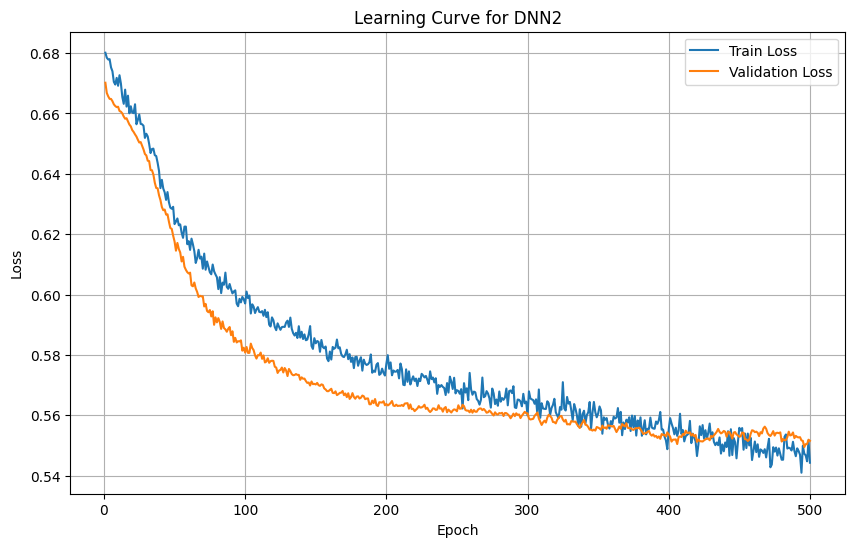

In [8]:
best_params=study.best_params
model = DNN_2(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              dropout3=best_params["dropout3"],
              dropout4=best_params["dropout4"]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_rate"])
criterion = nn.BCELoss()

num_epochs=500
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN2')
plt.legend()
plt.grid()
plt.show()

Accuracy: 61.96%
Precision: 0.4865
Recall: 0.3853
F1 Score: 0.4300
Matthews Correlation Coefficient: 0.1526
Specificity: 0.7586


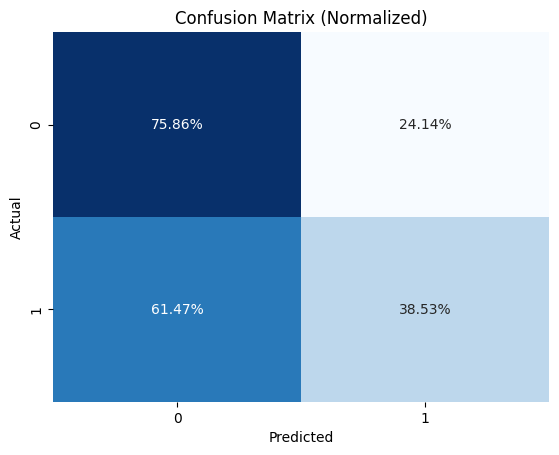

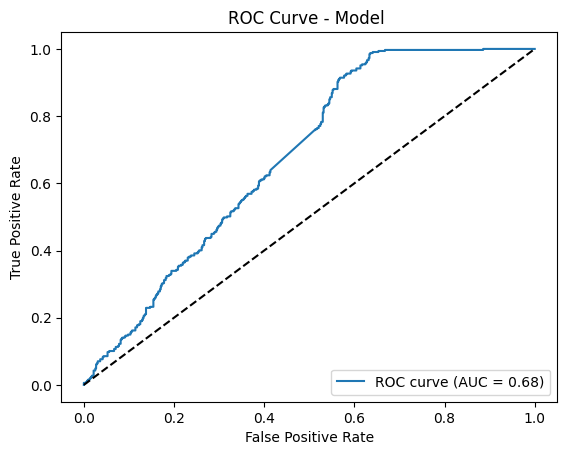

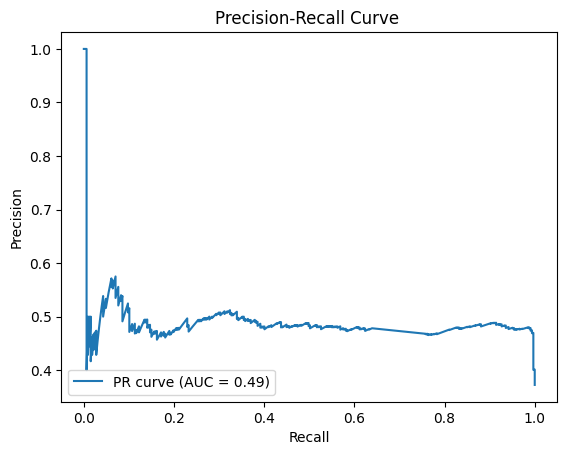

In [9]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [10]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_2.pth')



In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
           Dropout-6                   [-1, 16]               0
            Linear-7                    [-1, 8]             136
       BatchNorm1d-8                    [-1, 8]              16
           Dropout-9                    [-1, 8]               0
           Linear-10                    [-1, 4]              36
      BatchNorm1d-11                    [-1, 4]               8
          Dropout-12                    [-1, 4]               0
           Linear-13                    [-1, 1]               5
Total params: 1,785
Trainable params: 1